In [9]:
import json
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine
import psycopg2
# from config import db_password
import time

In [10]:
# 1. Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    return movie

In [1]:
# 1 Add the function that takes in three arguments;

# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def apply(wikipedia, kaggle, movielens):
    # Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata = pd.read_csv(kaggle, low_memory=False)
    ratings = pd.read_csv(movielens)
    print('this_is_better')

    # Open and read the Wikipedia data JSON file.
    with open(wikipedia, mode='r') as file:
        wiki_movies_raw = json.load(file)
    #wiki_movies_df = pd.DataFrame(wiki_movies_raw)
    #return wiki_movies_df, kaggle_metadata, ratings
    print('this_is_working')
    
    # 3. Write a list comprehension to filter out TV shows.
    clean_wiki_movies = [movie for movie in wiki_movies_raw
                         if ('Director' in movie or 'Directed by' in movie)
                         and 'imdb_link' in movie
                         and 'No. of episodes' not in movie]
    print('much_better')
    # check for alternatives titles in list\

    # 4. Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.

    def clean_movie(movie):
        movie = dict(movie) #create a non-destructive copy
        alt_titles = {}
        for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                    'Hangul','Hebrew','Hepburn','Japanese','Literally',
                    'Mandarin','McCune–Reischauer','Original title','Polish',
                    'Revised Romanization','Romanized','Russian',
                    'Simplified','Traditional','Yiddish']:
            if key in movie:
                alt_titles[key] = movie[key]
                movie.pop(key)
        if len(alt_titles) > 0:
            movie['alt_titles'] = alt_titles

        # merge column names
        def change_column_name(old_name, new_name):
            if old_name in movie:
                movie[new_name] = movie.pop(old_name)
        change_column_name('Adaptation by', 'Writer(s)')
        change_column_name('Country of origin', 'Country')
        change_column_name('Directed by', 'Director')
        change_column_name('Distributed by', 'Distributor')
        change_column_name('Edited by', 'Editor(s)')
        change_column_name('Length', 'Running time')
        change_column_name('Original release', 'Release date')
        change_column_name('Music by', 'Composer(s)')
        change_column_name('Produced by', 'Producer(s)')
        change_column_name('Producer', 'Producer(s)')
        change_column_name('Productioncompanies ', 'Production company(s)')
        change_column_name('Productioncompany ', 'Production company(s)')
        change_column_name('Released', 'Release Date')
        change_column_name('Release Date', 'Release date')
        change_column_name('Screen story by', 'Writer(s)')
        change_column_name('Screenplay by', 'Writer(s)')
        change_column_name('Story by', 'Writer(s)')
        change_column_name('Theme music composer', 'Composer(s)')
        change_column_name('Written by', 'Writer(s)')
        return movie
    
    # reruning list comprehension to clean wiki_movies and recreating the df
    clean_movies = [clean_movie(movie) for movie in clean_wiki_movies]
    print('clean_movies')

    #5.Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df= pd.DataFrame(clean_movies)
    
    #6.Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #dropping any imdb_id duplicates. If there is an error, capture and print the exception.
    try:        
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
    except:
        pass
    
    #7. Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.

    [[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]
    [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
    wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
    wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]
    print('keep_col')
    
    #8. Create a variable that will hold the non-null values from the “Box office” column.
    box_office = wiki_movies_df['Box office'].dropna()
    print('box_office')
    #9. Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)
    print('box_office')
    
    #10. Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one = r'\$\d+\.?\d*\s*[mb]illion'
    box_office.str.contains(form_one, flags=re.IGNORECASE).sum()
    print('box_officest')
    #11. Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\d{1,3}(?:,\d{3})+'
    box_office.str.contains(form_two, flags=re.IGNORECASE).sum()
    print('box_officestrr')
    
    #12. Add the parse_dollars function.
    def parse_dollars(s):
      
        #13. Clean the box office column in the wiki_movies_df DataFrame.
        #if s is not a string, return NaN
        if type(s) != str:
            return np.nan

        # if input is of the form $###.# million
        if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):
            
            # remove dollar sign and " million"
            s = re.sub('\$|\s|[a-zA-Z]','', s)
            # convert to float and multiply by a million
            value = float(s) * 10**6
            # return value
            return value

        # if input is of the form $###.# billion
        elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):
            # remove dollar sign and " billion"
            s = re.sub('\$|\s|[a-zA-Z]','', s)
            # convert to float and multiply by a billion
            value = float(s) * 10**9
            # return value
            return value

        # if input is of the form $###,###,###
        elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):
            # remove dollar sign and commas
            s = re.sub('\$|,','', s)

            # convert to float
            value = float(s)

            # return value
            return value

        # otherwise, return NaN
        else:
            return np.nan
        
        print('else_return')
    #Check and confirm that all of the box office data is entered as a string
    def is_not_a_string(x):
        return type(x) != str
    # Then add the following code:
    box_office[box_office.map(is_not_a_string)]
    # extract the values from box_office and dropping the columns
    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    wiki_movies_df.drop('Box office', axis=1, inplace=True)
    #14. Clean the budget column in the wiki_movies_df DataFrame.
    # Create a budget variable
    budget = wiki_movies_df['Budget'].dropna()
    #Convert any lists to strings:
    budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
    #Remove any values between a dollar sign and a hyphen (for budgets given in ranges):
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    # Parse the box office data, and apply them without modifications to the budget data
    matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
    matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
    budget[~matches_form_one & ~matches_form_two]
    # Remove with a regular expression the citation references (the numbers in square brackets).
    budget = budget.str.replace(r'\[\d+\]\s*', '')
    budget[~matches_form_one & ~matches_form_two]
    # Copy the line of code used to parse the box office values by changing "box_office" to "budget":
    wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

    # 15. Clean the release date column in the wiki_movies_df DataFrame.
    release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    # Parse the regular expressions forms with the following
    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'
    print('regex')
    # Extract the dates 
    release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)
    # Parse the dates
    wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)
    print('date')
    # 16. Clean the running time column in the wiki_movies_df DataFrame.
    # make a variable that holds the non-null values of running time in the DataFrame, converting lists to strings
    running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    # using string boundaries to find out how many runnign times look like.
    running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE).sum()
    # Find out what the other 366 entries look like.
    running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE) != True]
    #     # mark the beginning of the string, and accept other abbreviations of "minutes" by only searching up to the letter "m."
    running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE).sum()
    #     # remaining 17
    running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE) != True]
    # Extract digits, and  allow for both possible patterns. 
    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
    print('extract')
    #     # Apply a function that will convert the hour capture groups and minute capture groups to minutes;
    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
    #     # drop Running time from the dataset 
    wiki_movies_df.drop('Running time', axis=1, inplace=True)
    #     print('wiki_movies')
    print('drop_running_time')
    return wiki_movies_df, kaggle_metadata, ratings

In [20]:
# 2. Clean the Kaggle metadata.
        # check that all the values are either True or False
kaggle_metadata['adult'].value_counts()
            # Remove Bad Data
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]
            # keep rows where the adult column is False, and then drop the adult column.
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
        #      Convert Data Types
kaggle_metadata['video'] == 'True'
            # Assign back the Boolean column to 'video'.
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'
            # use the to_numeric() method from Pandas for numeric columns.
        # Set the errors= argument to 'raise', to know if there's any data that can't be converted to numbers.
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
            # convert release_date to datetime
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])
print('kaggle')

        # Reasonability Checks on Ratings Data
ratings.info(null_counts=True)
            #convert to df
pd.to_datetime(ratings['timestamp'], unit='s')
            #assign it to the timestamp column.
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
print('ratings')

kaggle
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB
ratings


In [21]:
# 3. Merged the two DataFrames into the movies DataFrame.
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on= 'imdb_id', suffixes=['_wiki','_kaggle']) 
print('merge')

merge


In [22]:
#Work on comparing columns (e.g. 'title, running time, budget, box office,')
movies_df[['title_wiki','title_kaggle']]
# checking on rows where the titles don't match (kaglle is more consistent)
movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]
# Show any rows where title_kaggle is empty (none after observation)
movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Release date,Country,Language,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count


drop


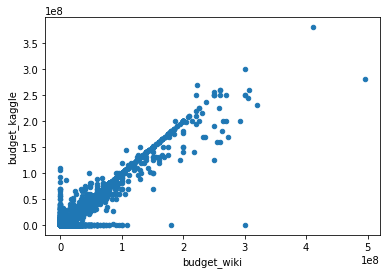

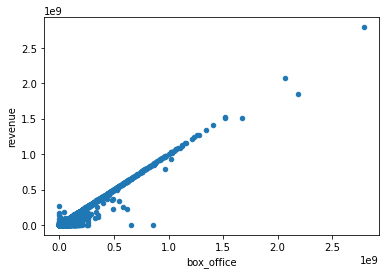

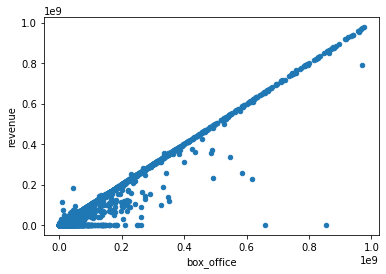

In [24]:
# fill missing values with zero
# movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')
movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')
movies_df.fillna(0).plot(x='box_office', y='revenue', kind='scatter')
#analysing the large data point at the scatter plot for everything less than $1 billion in box_office
movies_df.fillna(0)[movies_df['box_office'] < 10**9].plot(x='box_office', y='revenue', kind='scatter')

#looking for movie whose release date according to Wikipedia is after 1996, 
#but whose release date according to Kaggle is before 1965
movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')]
# getting the index of the row 'The Holiday' in the Wikipedia & 'From Here to Eternity' in the kaggle which got merged.
movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index
# dropping the row 
movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)
# Language data. comparing the value counts of each
movies_df['Language'].value_counts()
# convert the lists in Language to tuples. Initial code throws an error for 'value_counts' method.
movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)
# running value_counts on kaggle
movies_df['original_language'].value_counts(dropna=False)
# taking a look at a small number of samples
movies_df[['Production company(s)','production_companies']]
# Kaggle is more consistent and wiki will create more challenging translating it.
#Dropping the unconsistent columns from wiki
movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)
print('drop')

In [25]:
#4. Dropping uneccessary columns
movies_df.drop(columns=['budget_wiki','Release date','vote_count','Based on','Budget','homepage','overview','poster_path','homepage','spoken_languages','video','status','production_countries'], inplace=True)
print('col_new')

col_new


In [26]:
#   5. Add in the function to fill in the missing Kaggle data.
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
        , axis=1)
# 6. Call the function in Step 5 with the DataFrame and columns as the arguments.
    fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
    fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
    fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
   # 7. Filter the movies DataFrame for specific columns and converting lists to tuples for value_counts() to work.
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

In [27]:
# movies_df.columns.to_list

In [28]:
# 8. Rename the columns in the movies DataFrame.
movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'Cinematography': 'cinematography',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Editor(s)': 'edited_by',
                  'Writer(s)': 'written by',
                  'Composer(s)': 'composed_by',
                  'producers': 'produced_by'
                 }, axis='columns', inplace=True)

In [29]:
# movies_df.columns.to_list()

In [30]:
movies_df = movies_df.loc[:, ['imdb_id','kaggle_id','title','belongs_to_collection','wikipedia_url','year','imdb_link','starring','cinematography',
                              'country','director','distributor','edited_by','producers','written by',
                              'box_office','running_time','budget','genres',
                              'original_language','popularity','production_companies','release_date',
                             'revenue','tagline','vote_average']]

In [31]:
# 9. Transform and merge the ratings DataFrame.
    
    # include the rating data with the movie data.
# Use a groupby on the "movieId" and "rating" columns and take the count for each group
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count()
# rename the "userId" column to "count."
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1)
#  pivot this data so that movieId is the index, the columns will be all the rating values, 
# and the rows will be the counts for each rating value.
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
# rename the columns so they're easier to understand. prepend rating_ to each column with a list comprehension:
rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]
    # merge the rating counts into movies_df
# use a left merge, since we want to keep everything in movies_df:
movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')
# Fill missing values instead of zeros
movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)

# return wiki_movies_df, movies_with_ratings_df, movies_df

In [3]:
# 10. Create the path to your file directory and variables for the three files.
file_dir = 'Resources'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia-movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

In [13]:
# 11Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = apply(wiki_movies_df, kaggle_metadata, ratings)

this_is_better
this_is_working
much_better
clean_movies
keep_col
box_office
box_office
box_officest
box_officestrr
regex
date
extract
drop_running_time


In [16]:
# 12.Set the wiki_movies_df equal to the wiki_file variable. 
# 11. Set the DataFrames from the return statement equal to the file names in Step 11. 
wiki_movies_df = wiki_file
kaggle_metadata = kaggle_file
ratings = ratings_file

In [32]:
# 13. Check the wiki_movies_df DataFrame. 
wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Country,Language,...,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",United States,English,...,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0,1990-07-11,102
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",United States,English,...,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0,1990-05-17,114
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",United States,"[English, Lao]",...,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0,35000000.0,1990-08-10,113
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",United States,English,...,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0,12000000.0,1990-12-25,106
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",US,English,...,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0,25000000.0,1990-12-19,95


In [33]:
# 14. Check the movies_with_ratings_df DataFrame.
movies_with_ratings_df.head()

,imdb_id,kaggle_id,title,belongs_to_collection,wikipedia_url,year,imdb_link,starring,cinematography,country,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,tt0098987,9548,The Adventures of Ford Fairlane,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,"[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0098994,25501,"After Dark, My Sweet",NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0099005,11856,Air America,NaN,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,"[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0099012,8217,Alice,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0099018,25943,Almost an Angel,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,US,...,3.0,0.0,3.0,2.0,5.0,26.0,37.0,46.0,16.0,11.0


In [34]:
# 15. Check the movies_df DataFrame. 
movies_df.head()

,imdb_id,kaggle_id,title,belongs_to_collection,wikipedia_url,year,imdb_link,starring,cinematography,country,...,running_time,budget,genres,original_language,popularity,production_companies,release_date,revenue,tagline,vote_average
0,tt0098987,9548,The Adventures of Ford Fairlane,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,"[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,...,102,49000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",en,3.834949,[{'name': 'Twentieth Century Fox Film Corporat...,1990-07-11,20423389.0,Kojak. Columbo. Dirty Harry. Wimps.,6.2
1,tt0098994,25501,"After Dark, My Sweet",NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,...,114,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",en,7.349189,"[{'name': 'Avenue Pictures Productions', 'id':...",1990-08-24,0.0,All they risked was everything.,6.5
2,tt0099005,11856,Air America,NaN,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,"[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,United States,...,113,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,10.274376,"[{'name': 'IndieProd Company Productions', 'id...",1990-08-10,33461269.0,The few. The proud. The totally insane.,5.3
3,tt0099012,8217,Alice,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,United States,...,106,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,7.196816,"[{'name': 'Orion Pictures', 'id': 41}]",1990-12-25,0.0,NaN,6.3
4,tt0099018,25943,Almost an Angel,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,US,...,95,0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 35, 'na...",en,2.862209,"[{'name': 'Paramount Pictures', 'id': 4}]",1990-12-21,0.0,Who does he think he is?,5.6
